# Trabalho 1
## OCR - Optical Character Recognizer

Aluno: Bruno Flávio Ferreira - 9791330

Na primeira parte do trabalho, foi utilizada a técnica de Transfer Learning, para treinar uma rede neural capaz de reconhecer caracteres. 

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import scipy.io as io
import tensorflow_hub as hub
from shutil import copyfile
from tensorflow.keras import layers
import pandas as pd
import PIL.Image as Image
import os
import numpy as np
import time

Primeiro, carregamos o dataset Chars74K, 75% é carregado como dataset de treinamento, 25% como validação

In [7]:
IMAGE_SHAPE = (224, 224)
dataset_folder = './TrainSet'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.25)
image_data = image_generator.flow_from_directory(dataset_folder, target_size=IMAGE_SHAPE, subset='training')
image_validation = image_generator.flow_from_directory(dataset_folder  , target_size=IMAGE_SHAPE, subset='validation')

Found 5806 images belonging to 62 classes.
Found 1899 images belonging to 62 classes.


A Rede que será utilizada para o Transfer Learning é a Inception V3 da Google.

Primeiramente, foi carregado o Inception V3 e executado sobre algumas imagens do dataset para vermos as predições antes de realizarmos a técnica do Transfer Learning

In [8]:
classifier_url ="https://tfhub.dev/google/tf2-preview/inception_v3/classification/4" #@param {type:"string"}
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 62)
(32, 1001)


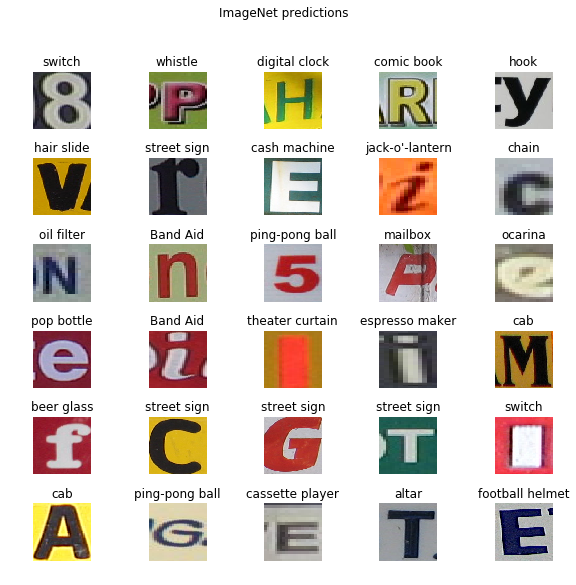

In [9]:
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

result_batch = classifier.predict(image_batch)
print(result_batch.shape)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

plt.show()

### Treinamento do classificador
Agora, carregamos uma versão do Inception V3 sem a camada final de predição, para podermos treinar no novo dataset e obtermos a classificação desejada

In [10]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4" #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)
feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()


(32, 2048)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 62)                127038    
Total params: 21,929,822
Trainable params: 127,038
Non-trainable params: 21,802,784
_________________________________________________________________


Agora, nós treinamos o modelo com o dataset Chars74K

In [11]:
predictions = model(image_batch)
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=15,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=image_validation,
                              callbacks = [batch_stats_callback])


Epoch 1/15
182/182 [==============================] - 49s 269ms/step - loss: 2.5887 - acc: 0.4375 - val_loss: 2.2215 - val_acc: 0.4413
Epoch 2/15
182/182 [==============================] - 41s 226ms/step - loss: 1.3976 - acc: 0.6875 - val_loss: 1.9872 - val_acc: 0.4882
Epoch 3/15
182/182 [==============================] - 41s 226ms/step - loss: 0.9974 - acc: 0.7812 - val_loss: 1.8751 - val_acc: 0.5134
Epoch 4/15
182/182 [==============================] - 41s 225ms/step - loss: 0.7631 - acc: 0.7812 - val_loss: 1.8670 - val_acc: 0.5108
Epoch 5/15
182/182 [==============================] - 41s 225ms/step - loss: 0.6027 - acc: 0.8438 - val_loss: 1.8338 - val_acc: 0.5182
Epoch 6/15
182/182 [==============================] - 41s 225ms/step - loss: 0.4876 - acc: 0.7812 - val_loss: 1.7936 - val_acc: 0.5340
Epoch 7/15
182/182 [==============================] - 41s 224ms/step - loss: 0.4015 - acc: 0.8125 - val_loss: 1.8447 - val_acc: 0.5313
Epoch 8/15
182/182 [==============================] - 4

Com o modelo treinado, podemos visualizar os gráficos de como as medidas de Loss e Accuracy se modificaram com os passos do treinamento

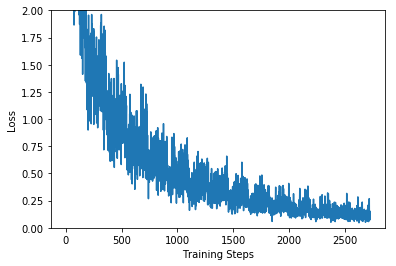

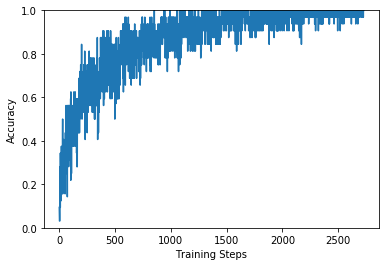

In [12]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)


### Testando o classificador

Após todos os passos completos, podemos executar a predição sobre as mesmas imagens que foram classificadas pelo ImageNet anteriormente e vermos os resultados:

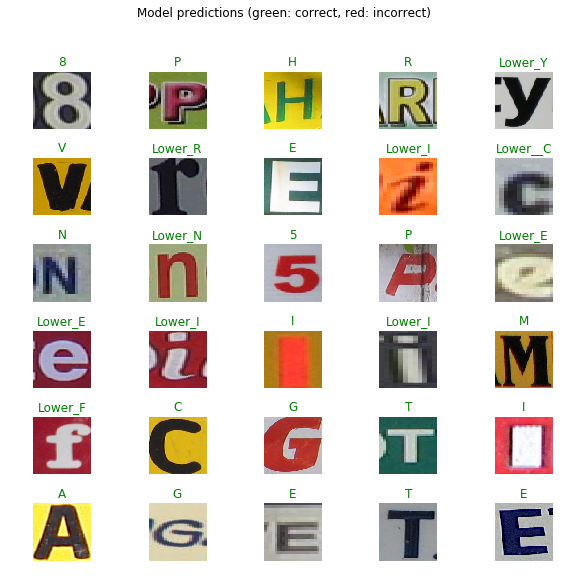

In [13]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

Também, podemos executar a predição em imagens do dataset de validação:

Validation batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 62)


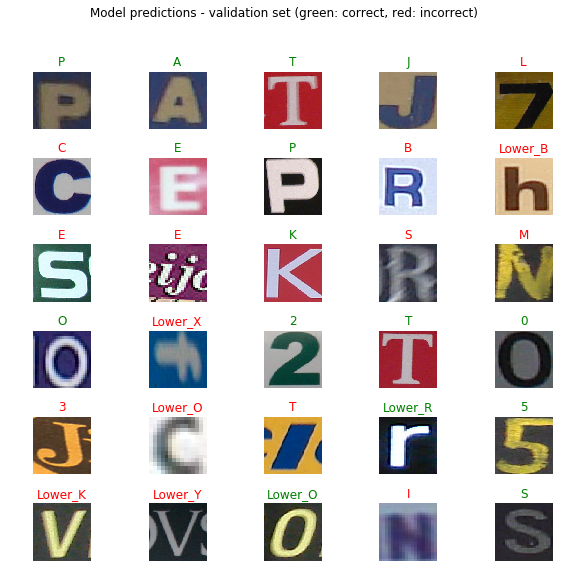

In [14]:
for validation_batch, label_batch in image_validation:
  print("Validation batch shape: ", validation_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break  

predicted_batch = model.predict(validation_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(validation_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions - validation set (green: correct, red: incorrect)")



### Exportando o modelo
Por ultimo, precisamos exportar o modelo para podermos utilizarmos posteriormente

In [0]:
t = time.time()

export_path = "./saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path